# ESN Model Codes

## Dependencies

In [65]:
import os
import shutil
import random; random.seed(42)

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn
from reservoirpy import mat_gen, ESN

## Directories:

In [66]:
# training data
train_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/train'
train_dir_video = '/raid/cs152/zxaa2018/penndulum//train_and_test_split/dpc_dataset_traintest_4_200_h264/train'

# test data
test_inputs_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/test_inputs/'
test_targets_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/test_targets/'
test_targets_video = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_h264/test_targets/'

# validation data
validation_inputs_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/validation_inputs/'
validation_targets_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/validation_targets/'
validation_targets_video = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_h264/validation_targets/'

## Functions and Class Definitions

### Data Transformation Functions

In [67]:
# some constants
DEFAULT_X_RED, DEFAULT_Y_RED = (240, 232)

PIXEL_DISTANCE_GREEN_TO_RED = 118 # approx. value | calculated with the Pythagorean theorem and averaged: np.sqrt((y_green-y_red)**2 + (x_green-x_red)**2)
PIXEL_DISTANCE_BLUE_TO_GREEN = 90 # approx. value | calculated with the Pythagorean theorem and averaged: np.sqrt((y_blue-y_green)**2 + (x_blue-x_green)**2)

def raw_to_pixel(l):
    '''Convert the raw coordinates to pixel coordinates.'''
    assert isinstance(l, list)
    return [x/5 for x in l]


def pixel_to_raw(l):
    '''Convert the pixel coordinates to raw coordinates.'''
    assert isinstance(l, list)
    return [x*5 for x in l]


def raw_cartesian_to_polar_angles(l):
    '''Convert the cartesian coordinates to polar coordinates.'''
    assert isinstance(l, list)
    x_red, y_red, x_green, y_green, x_blue, y_blue = raw_to_pixel(l)

    #angle_green_red = np.arctan((y_green-y_red)/(x_green-x_red+0.001))
    #angle_blue_green = np.arctan((y_blue-y_green)/(x_blue-x_green+0.001))

    angle_green_red = np.arctan2(y_red-y_green+1e-4, x_green-x_red+1e-4) + np.pi * 0.5
    angle_blue_green = np.arctan2(y_green-y_red + 1e-4, x_blue-x_green+0.001) + np.pi * 0.5
    
    return [np.sin(angle_green_red), np.cos(angle_green_red), np.sin(angle_blue_green), np.cos(angle_blue_green)]

def raw_cartesian_to_thetas(l):
    '''Convert the cartesian coordinates to polar coordinates.'''
    assert isinstance(l, list)
    x_red, y_red, x_green, y_green, x_blue, y_blue = raw_to_pixel(l)\

    angle_green_red = np.arctan2(y_red-y_green+1e-4, x_green-x_red+1e-4) + np.pi * 0.5
    angle_blue_green = np.arctan2(y_green-y_red + 1e-4, x_blue-x_green+0.001) + np.pi * 0.5
    
    return [angle_green_red, angle_blue_green]

def polar_angles_to_raw_cartesian(l):
    '''Convert the polar coordinates back to cartesian coordinates.'''
    assert isinstance(l, list)
    sin_angle_green_red, cos_angle_green_red, sin_angle_blue_green, cos_angle_blue_green = l
    
    y_green = PIXEL_DISTANCE_GREEN_TO_RED * sin_angle_green_red + DEFAULT_Y_RED
    x_green = PIXEL_DISTANCE_GREEN_TO_RED * cos_angle_green_red + DEFAULT_X_RED

    y_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * sin_angle_blue_green + y_green
    x_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * cos_angle_blue_green + x_green
    
    return pixel_to_raw([DEFAULT_X_RED, DEFAULT_Y_RED, x_green, y_green, x_blue, y_blue])

### Data reading functions

Parsing training data:
training data x-y matching is like this:
x: a list of 4 frames
y: the frame that follows

In [68]:
def parse_csv_esn(csv_file):
    '''Given a csv file and a length of sequence, return the sequence in list of list'''
    X_data = []
    f = pd.read_csv(csv_file, header=None, delim_whitespace=True, engine='python')
    temp = []
    for i, row in f.iterrows():
        next_frame = raw_cartesian_to_polar_angles(row.to_list())
        X_data.append(next_frame.copy())
        
    return X_data

In [69]:
def parse_csv_esn_angular(csv_file):
    '''Given a csv file and a length of sequence, return the sequence in list of list'''
    X_data = []
    f = pd.read_csv(csv_file, header=None, delim_whitespace=True, engine='python')
    temp = []
    for i, row in f.iterrows():
        next_frame = row.to_list()
        next_frame = raw_cartesian_to_thetas(next_frame)
        X_data.append(next_frame.copy())
        
    return X_data

In [70]:
def get_seq_list(source_dir):
    result = []
    name = []
    for filename in tqdm([x for x in os.listdir(source_dir) if not x.startswith('.')]):
        # load in a file
        name.append(filename)
        X_data = parse_csv_esn(os.path.join(source_dir, filename))
        result.append(X_data)
    return result, name

In [71]:
def normalize_sequence(sequence: np.ndarray):
    '''Given a sequence in shape (n,6), normalize the sequence to [-1,1]'''
    # get range of x coords 0,2,4
    x_factor = (sequence[:,[0,2,4]].max() - sequence[:,[0,2,4]].min()) * 0.5
    y_factor = (sequence[:,[1,3,5]].max() - sequence[:,[1,3,5]].min()) * 0.5

    sequence[:,[0,2,4]] = sequence[:,[0,2,4]] / max(x_factor,1e-6) - 0.5
    sequence[:,[1,3,5]] = sequence[:,[1,3,5]] / max(y_factor, 1e-6) - 0.5

    return sequence, (x_factor, y_factor)

def denormalize_sequence(sequence: np.array, factors: tuple):
    '''Given a sequence in shape (n,6), normalized to [-1,1], and the normalize factors along the x, y axis, return the denormalized sequence'''
    sequence[:,[0,2,4]] = (sequence[:,[0,2,4]] + 0.5) * factors[0]
    sequence[:,[1,3,5]] = (sequence[:,[1,3,5]] + 0.5) * factors[1]

    return sequence
    

In [72]:
def normalize_sequence_by_pivot(sequence: np.ndarray):
    '''Given a sequence in shape (n,6), normalize the sequence to [-1,1]'''
    # get range of coords of first  axis
    a_factor = (sequence[:,[0,1]].max() - sequence[:,[0,1]].min()) * 0.5
    b_factor = (sequence[:,[2,3]].max() - sequence[:,[2,3]].min()) * 0.5
    c_factor = (sequence[:,[4,5]].max() - sequence[:,[4,5]].min()) * 0.5

    a_shift = sequence[:,[0,1]].min()
    b_shift = sequence[:,[2,3]].min()
    c_shift = sequence[:,[4,5]].min()

    sequence[:,[0,1]] = (sequence[:,[0,1]] - a_shift) / max(a_factor,1e-6) - 1
    sequence[:,[2,3]] = (sequence[:,[2,3]] - b_shift) / max(b_factor,1e-6) - 1
    sequence[:,[4,5]] = (sequence[:,[4,5]] - c_shift) / max(c_factor,1e-6) - 1

    sequence[:,[0,2,4]] = sequence[:,[0,2,4]] * -1.0

    return sequence, (a_factor, b_factor, c_factor, a_shift, b_shift, c_shift)

def denormalize_sequence_by_pivot(sequence: np.array, factors: tuple):
    '''Given a sequence in shape (n,6), normalized to [-1,1], and the normalize factors along the x, y axis, return the denormalized sequence'''
    sequence[:,[1,3,5]] = sequence[:,[1,3,5]] * -1.0
    sequence[:,[0,1]] = (sequence[:,[0,1]] + 1) * factors[0] + factors[3]
    sequence[:,[2,3]] = (sequence[:,[0,1]] + 1) * factors[1] + factors[4]
    sequence[:,[4,5]] = (sequence[:,[0,1]] + 1) * factors[2] + factors[5]

    return sequence

In [73]:
def make_data_continuous(seq: np.array):
    for i,datapoint in enumerate(seq[:,0][:-1]):
        if seq[:,0][i+1] - datapoint > np.pi * 2 - 0.1:
            seq[:,0][i+1:] -= np.pi * 2
        elif datapoint - seq[:,0][i+1] > np.pi * 2 - 0.1:
            seq[:,0][i+1:] += np.pi * 2
        else:
            continue
    for i,datapoint in enumerate(seq[:,1][:-1]):
        if seq[:,1][i+1] - datapoint > np.pi * 2 - 0.1:
            seq[:,1][i+1:] -= np.pi * 2
        elif datapoint - seq[:,1][i+1] > np.pi:
            seq[:,1][i+1:] += np.pi * 2
        else:
            continue
    return seq
    


### Dataset Definition

In [74]:
class NormalizedDataset():
    def __init__(self,X_list: list, name_list: list):
        self.sample_List = []
        self.factor_list = []
        self.name_dict = {}
        for i, (seq, name) in enumerate(zip(X_list, name_list)):
            self.name_dict[i] = name
            norm_seq, factors = normalize_sequence_by_pivot(np.array(seq, dtype=float))
            self.sample_List.append(norm_seq)
            self.factor_list.append(factors)

    def __len__(self):
        return len(self.sample_list)
    
    def getFactor(self, index: int):
        return self.x_factor_list[index], self.y_factor_list[index]

In [75]:
class Dataset():
    def __init__(self,X_list: list, name_list: list):
        self.sample_List = []
        self.name_dict = {}
        for i, (seq, name) in enumerate(zip(X_list, name_list)):
            self.name_dict[i] = name
            self.sample_List.append(np.array(seq, dtype=np.float32))

    def __len__(self):
        return len(self.sample_list)

In [76]:
class DoublePendulumDataset(torch.utils.data.Dataset):
    '''
    Generate a LSTM dataset from a normalized dataset
    '''
    def __init__(self,dataset_n:NormalizedDataset):
        self.X_list = []
        self.y_list = []
        for seq in tqdm(dataset_n.sample_List):
            for i in range(seq.shape[0] - 5):
                self.X_list.append(torch.from_numpy(seq[[i,i+1,i+2,i+3],:]))
                self.y_list.append(torch.from_numpy(seq[[i+4],:]))
        self.sample_list = list(zip(self.X_list, self.y_list))

    
    def __getitem__(self,index):
        X_sample,y_sample = self.sample_list[index]
        return torch.from_numpy(np.array(X_sample)).float(),torch.from_numpy(np.array(y_sample)).float()
    
    def __len__(self):
        return len(self.sample_list)

In [77]:
class AngularDatast():
    def __init__(self,X_list: list, name_list: list):
        self.sample_List = []
        self.name_dict = {}
        for i, (seq, name) in enumerate(zip(X_list, name_list)):
            seq_c = make_data_continuous(np.array(seq, dtype=float))
            self.name_dict[i] = name
            self.sample_List.append(seq_c)

    def __len__(self):
        return len(self.sample_list)

### Model Definition

Data Visualization Functions

In [78]:
def plot_comparison_with_warmup(Xgen, Xgen_test, warm_up, length, axis1, axis2):
    t = np.arange(length)
    fig = plt.figure(figsize = (13,5))
    
    plt.gca().invert_yaxis()
    plt.subplot((121))
    plt.title(f"Ground Truth, first {length} frame")
    plt_x = [y[1] for y in Xgen_test[:,[axis1, axis2][:length]]]
    plt_y = [y[0] for y in Xgen_test[:,[axis1, axis2][:length]]]
    warm_x = [y[1] for y in warm_up[:,[axis1, axis2]]]
    warm_y = [y[0] for y in warm_up[:,[axis1, axis2]]]

    plt.plot(warm_x, warm_y, lw=1,color="lightgrey", zorder=0)
    plt.scatter(warm_x, warm_y,lw=0.5, c = 'red', s=2)
    plt.plot(plt_x, plt_y, lw=1,color="lightgrey", zorder=0)
    plt.scatter(plt_x, plt_y,lw=0.5, c = t[:len(plt_x)],cmap="viridis", s=2)
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")

    plt.subplot((122))
    plt.title(f"Prediction, first {length} frame")
    plt_x_res = [y[1] for y in Xgen[:,[axis1, axis2]][:length]]
    plt_y_res = [y[0] for y in Xgen[:,[axis1, axis2]][:length]]

    plt.plot(warm_x, warm_y, lw=1,color="lightgrey", zorder=0)
    plt.scatter(warm_x, warm_y,lw=0.5, c = 'red', s=2)
    plt.plot(plt_x_res, plt_y_res, lw=1,color="lightgrey", zorder=0)
    plt.scatter(plt_x_res, plt_y_res,lw=0.5, c = t[:len(plt_x)],cmap="viridis", s=2)
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")

In [79]:
def plot_sequence(seq, a1, a2):

    length = seq.shape[0]
    t = np.arange(length)
    
    plt.title(f"Timeserie - {length} timesteps")

    plt.plot(seq[:,a2], seq[:,a1], color="lightgray", zorder=0)
    plt.scatter(seq[:,a2], seq[:,a1], c=t[:length], cmap="viridis", s=1, zorder=1)

    plt.xlabel("$x$")
    plt.ylabel("$y$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    #plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

## Training, testing and analysis Codes

### Loading Training Data

In [80]:
Seq_train_p, Seq_train_name_p = get_seq_list(train_dir)
dataset_p = Dataset(Seq_train_p, Seq_train_name_p)

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:36<00:00,  1.10it/s]


In [81]:
dataset_p.sample_List = [dataset_p.sample_List[0]]+dataset_p.sample_List[2:5]+dataset_p.sample_List[6:10]+dataset_p.sample_List[11:]

### Hyperparameter and Model instantiate

In [82]:
class ESNModel():
    def __init__(self, units, dim, input_scaling, input_connectivity, input_bias, seed, spectral_radius, density, leak_rate, regularization):
        self.units = units
        self.dim = dim
        self.input_scaling = input_scaling
        self.input_connectivity = input_connectivity
        self.input_bias = input_bias
        self.seed = seed
        self.spectral_radius = spectral_radius
        self.density = density
        self.leak_rate = leak_rate
        self.regularization = regularization
        
        self.Win = mat_gen.generate_input_weights(self.units, self.dim,    input_scaling=self.input_scaling, proba=self.input_connectivity, input_bias=self.input_bias,seed=self.seed)
        self. W = mat_gen.generate_internal_weights(self.units, sr=self.spectral_radius, proba=self.density, seed=self.seed)
        self.reservior = ESN(self.leak_rate, self.W, self.Win, ridge = self.regularization)

    def train_on_sequence(self, dataset: NormalizedDataset, index = 0, train_length = 400, forecast = 1):
        '''
        Given an index of of a sequence in the dataset (default to 0), train the reservoir on that sequence.
        '''
        seq = dataset.sample_List[index]
        states = self.reservior.train(seq[:train_length], seq[forecast: forecast + train_length], verbose = False)
        return states

    def generate_on_sequence(self, dataset, index = 0, warm_up_length = 100, nb_generations = 300, start = 0):
        '''Given a sequence of a dataset, generate on that sequence'''
        test_X = dataset
        warming_inputs = test_X[start: start + warm_up_length]
        Xgen_test = test_X[start + warm_up_length : start + nb_generations + warm_up_length]
        Xgen, states, warming_out, warming_states = self.reservior.generate(nb_generations, warming_inputs=warming_inputs, verbose = False)
        return Xgen, Xgen_test, warming_inputs, states, warming_out, warming_states

    def reset(self):
        '''reset the model'''
        self.Win = mat_gen.generate_input_weights(self.units, self.dim,input_scaling=self.input_scaling, proba=self.input_connectivity, input_bias=self.input_bias,seed=self.seed)
        self. W = mat_gen.generate_internal_weights(self.units, sr=self.spectral_radius, proba=self.density, seed=self.seed)
        self.reservior = ESN(self.leak_rate, self.W, self.Win, ridge = self.regularization)

In [83]:
def plot_time_series(seq, a1, l):

    #length = seq.shape[0]
    t = np.linspace(0, l - 1, l)
     
    plt.title(f"Timeserie - {l} timesteps")

    plt.plot(t, seq[:,a1][:l], color="lightgray", zorder=0)
    plt.scatter(t, seq[:,a1][:l], c=t[:l], cmap="viridis", s=1, zorder=1)

    plt.xlabel("$x$")
    plt.ylabel("$y$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    plt.tight_layout()
    plt.show()

Task:
- write a function quantifying error for each prediction.
  let's use the Y distance
- train with different number of sequences, and test. (Maybe test on #39).

In [84]:
def error_seq(Xgen, Xgen_test):
    '''
    Given ground truth and prediction, calculate the mean distance between the endpoints and then the percentage error with respect to the range the endpoints can move (2.0).
    '''
    diff = Xgen - Xgen_test
    dist = np.sqrt(np.square(diff[:,4])+np.square(diff[:,5]))
    DIST_CENTER = 2.0
    min_off_center_percentage = np.mean(dist) / DIST_CENTER
    return min_off_center_percentage

In [85]:
'''
Defining our hyperparameters.
'''

units = 500
leak_rate = 0.1
spectral_radius = 25.0
input_scaling = 0.5
density = 0.1
input_connectivity = 1.0
regularization = 1e-7
seed = 1000

model = ESNModel(units=units, dim=4, input_scaling=input_scaling, input_connectivity=input_connectivity, input_bias= True, seed = seed, spectral_radius= spectral_radius, density=density, leak_rate=leak_rate, regularization= regularization)

In [91]:
from tqdm import tqdm

for i in tqdm(range(len(dataset_p.sample_List))):
    states = model.train_on_sequence(dataset_p, i, train_length = dataset_p.sample_List[i].shape[0]-1,forecast= 1)

100%|███████████████████████████████████████████████████████████████████████████████████| 37/37 [01:44<00:00,  2.83s/it]


In [46]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

from jax.experimental import stax
from jax.experimental import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

In [47]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [48]:
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
  t1, t2 = q     # theta 1 and theta 2
  w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2
  
  # potential energy (V)
  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2

  return T - V

In [49]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
  a2 = (l1 / l2) * jnp.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
  f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return jnp.stack([w1, w2, g1, g2])

In [50]:
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

In [51]:
# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
  L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
  return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [52]:
# choose an initial state
x1 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)

t2 = np.linspace(0, 20, num=301)
%time x1_analytical = jax.device_get(solve_analytical(x1, t2))

CPU times: user 903 ms, sys: 4.23 ms, total: 907 ms
Wall time: 895 ms


In [53]:
print(x1_analytical[0])

[1.3463968 2.3561945 0.        0.       ]


In [93]:
x1_model = model.generate_on_sequence(x1_analytical)

In [100]:
x1_model = x1_model[0]

In [112]:
x1_model = np.insert(x1_model, 0, x1_analytical[0], axis=0)
print(len(x1_model))
print(x1_model[0])

301
[1.3463968 2.3561945 0.        0.       ]


In [113]:
print(x1_model[0])

[1.3463968 2.3561945 0.        0.       ]


In [114]:
def make_plot(i, cart_coords, l1, l2, max_trail=30, trail_segments=20, r = 0.05):
    # Plot and save an image of the double pendulum configuration for time step i.
    plt.cla()

    x1, y1, x2, y2 = cart_coords
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k') # rods
    c0 = Circle((0, 0), r/2, fc='k', zorder=10) # anchor point
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10) # mass 1
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10) # mass 2
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # plot the pendulum trail (ns = number of segments)
    s = max_trail // trail_segments
    for j in range(trail_segments):
        imin = i - (trail_segments-j)*s
        if imin < 0: continue
        imax = imin + s + 1
        alpha = (j/trail_segments)**2 # fade the trail into alpha
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Center the image on the fixed anchor point. Make axes equal.
    ax.set_xlim(-l1-l2-r, l1+l2+r)
    ax.set_ylim(-l1-l2-r, l1+l2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    # plt.savefig('./frames/_img{:04d}.png'.format(i//di), dpi=72)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * np.sin(t1)
  y1 = -l1 * np.cos(t1)
  x2 = x1 + l2 * np.sin(t2)
  y2 = y1 - l2 * np.cos(t2)
  return x1, y1, x2, y2

def fig2image(fig):
  fig.canvas.draw()
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  image = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  return image

In [115]:
L1, L2 = 1, 1
theta1mod, theta2mod = x1_model[:, 0], x1_model[:, 1]
cart_coords_mod = radial2cartesian(theta1mod, theta2mod, L1, L2)

L1, L2 = 1, 1
theta1ana, theta2ana = x1_analytical[:, 0], x1_analytical[:, 1]
cart_coords_ana = radial2cartesian(theta1ana, theta2ana, L1, L2)

In [116]:
def cart_coords_over_time(cart_coords):
    x1, y1, x2, y2 = cart_coords
    
    length = len(x2)
    t = np.arange(length)
    
    plt.title("ESN Double Pendulum " + f"Timeseries - {length - 1} timesteps")

    plt.plot(x2, y2, marker='.', color="lightgray", zorder=0)
    plt.scatter(x2, y2, marker='o', c=t[:length], cmap="viridis", s=10, zorder=1)

    plt.xlabel("$x$")
    plt.ylabel("$y$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    #plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

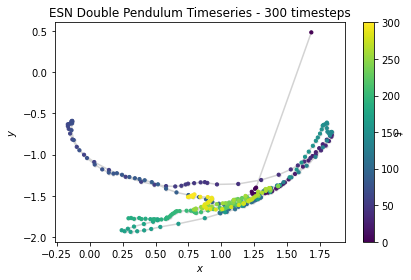

In [117]:
cart_coords_over_time(cart_coords_mod)

0/300
1/300 2/300 3/300 4/300 5/300 6/300 7/300 8/300 9/300 10/300 11/300 12/300 13/300 14/300 15/300 16/300 17/300 18/300 19/300 20/300
21/300 22/300 23/300 24/300 25/300 26/300 27/300 28/300 29/300 30/300 31/300 32/300 33/300 34/300 35/300 36/300 37/300 38/300 39/300 40/300
41/300 42/300 43/300 44/300 45/300 46/300 47/300 48/300 49/300 50/300 51/300 52/300 53/300 54/300 55/300 56/300 57/300 58/300 59/300 60/300
61/300 62/300 63/300 64/300 65/300 66/300 67/300 68/300 69/300 70/300 71/300 72/300 73/300 74/300 75/300 76/300 77/300 78/300 79/300 80/300
81/300 82/300 83/300 84/300 85/300 86/300 87/300 88/300 89/300 90/300 91/300 92/300 93/300 94/300 95/300 96/300 97/300 98/300 99/300 100/300
101/300 102/300 103/300 104/300 105/300 106/300 107/300 108/300 109/300 110/300 111/300 112/300 113/300 114/300 115/300 116/300 117/300 118/300 119/300 120/300
121/300 122/300 123/300 124/300 125/300 126/300 127/300 128/300 129/300 130/300 131/300 132/300 133/300 134/300 135/300 136/300 137/300 138/30

Moviepy - Done !
Moviepy - video ready ESNDoublePendulumMotion.mp4


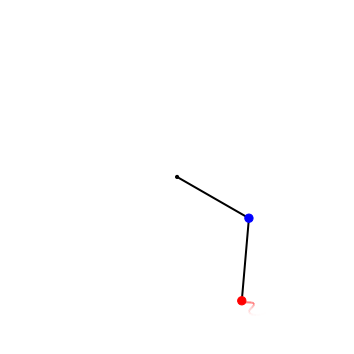

In [118]:
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

import warnings
warnings.filterwarnings("ignore")

images = []
di = 1
N = 300
for i in range(0, N, di):
  print("{}/{}".format(i // di, N // di), end='\n' if i//di%20==0 else ' ')
  make_plot(i, cart_coords_mod, 1, 1)
  images.append( fig2image(fig) )

analytical_clip = ImageSequenceClip(images, fps=25)
analytical_clip.write_videofile("ESNDoublePendulumMotion.mp4")

In [119]:
def cart_error_over_time(cart_coords_model, cart_coords_ana):
    x11, y11, x21, y21 = cart_coords_ana
    x12, y12, x22, y22 = cart_coords_model
    
    distance_1 = np.sqrt((np.square(np.absolute(x11 - x12)) + np.square(np.absolute(y11 - y12))))
    distance_2 = np.sqrt((np.square(np.absolute(x21 - x22)) + np.square(np.absolute(y21 - y22))))
    
    index = np.arange(np.size(distance_1))
    
    plt.plot(index, distance_1, label='first pendulum arm')
    plt.plot(index, distance_2, label='second pendulum arm')
    plt.legend(loc="upper right")
    
    plt.title('Error Over Time by Distance')
    plt.xlabel('Timestep')
    plt.ylabel('Distance')

    plt.show()

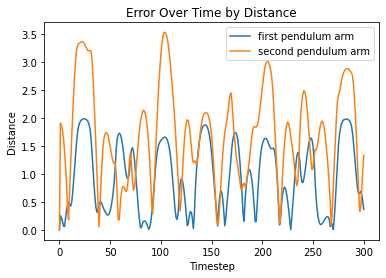

In [120]:
cart_error_over_time(cart_coords_mod, cart_coords_ana)

In [123]:
def theta_error_over_time(theta1_model, theta2_model, theta1_ana, theta2_ana):
    distance_1 = theta1_model - theta1_ana
    distance_2 = theta2_model - theta2_ana
    
    index = np.arange(np.size(distance_1))
    
    plt.plot(index, distance_1, label='first pendulum arm')
    plt.plot(index, distance_2, label='second pendulum arm')
    plt.legend(loc="lower left")
    
    plt.title('Error Over Time by Angle')
    plt.xlabel('Timestep')
    plt.ylabel('Angle (radians)')

    plt.show()

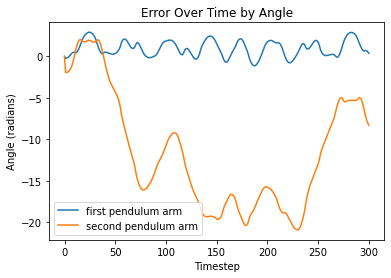

In [124]:
theta_error_over_time(theta1mod, theta2mod, theta1ana, theta2ana)